# 라이브러리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.3 MB/s 


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

import warnings 
warnings.filterwarnings('ignore')

# CSV 파일 읽기

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/프로젝트/중고차 가격 예측 경진대회/train.csv')
test = pd.read_csv('/content/drive/MyDrive/프로젝트/중고차 가격 예측 경진대회/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/프로젝트/중고차 가격 예측 경진대회/sample_submission.csv')

# 데이터 정보

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1015 non-null   int64 
 1   title         1015 non-null   object
 2   odometer      1015 non-null   int64 
 3   location      1015 non-null   object
 4   isimported    1015 non-null   object
 5   engine        1015 non-null   object
 6   transmission  1015 non-null   object
 7   fuel          1015 non-null   object
 8   paint         1015 non-null   object
 9   year          1015 non-null   int64 
 10  target        1015 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 87.4+ KB


# 결측치 확인

In [ ]:
train.isna().sum()

id              0
title           0
odometer        0
location        0
isimported      0
engine          0
transmission    0
fuel            0
paint           0
year            0
target          0
dtype: int64

# 상관관계

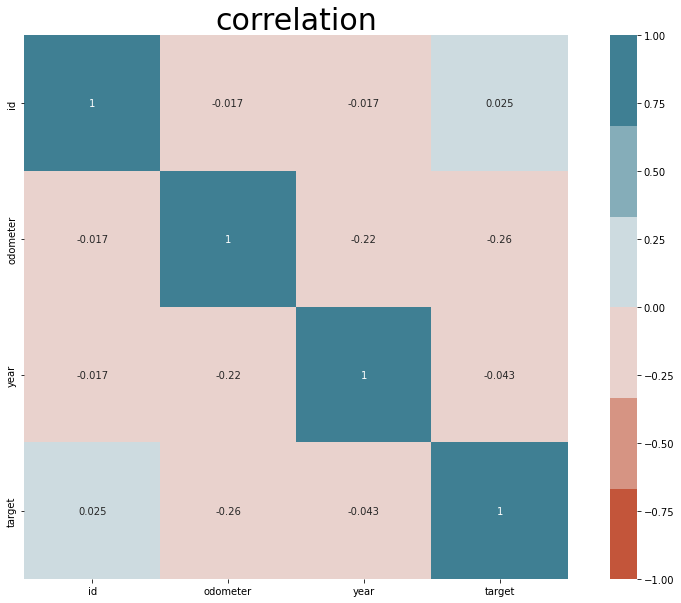

In [ ]:
number_train = train.select_dtypes(np.number)

corr = number_train.corr()
plt.figure(figsize=(15, 10)) # 가로, 세로 

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, # 상관계수의 범위
    cmap=sns.diverging_palette(20, 220), #색상을 변화시킵니다.
    square=True, 
    annot=True
)

#ax.set_xticklabels(ax.get_xticklabels(),rotation = 30) # x label 회전

plt.title('correlation', fontsize=30)
plt.show()

# 데이터 고유값

## 1. title

In [ ]:
train['title'].unique()

array(['Toyota RAV 4', 'Toyota Land Cruiser',
       'Land Rover Range Rover Evoque', 'Lexus ES 350', 'Toyota Venza',
       'Toyota Corolla', 'Land Rover Range Rover Sport', 'Pontiac Vibe',
       'Toyota Tacoma', 'Lexus RX 350', 'Ford Escape', 'Honda Civic',
       'Volvo XC90', 'BMW 750', 'Infiniti JX', 'Honda Accord',
       'Mercedes-Benz ML 350', 'Toyota Camry', 'Hyundai Azera',
       'Lexus GX 460', 'BMW 325', 'Toyota Sienna', 'Honda Fit',
       'Honda CR-V', 'Hyundai Tucson', 'Ford Transit', 'Jaguar XJ8',
       'BMW X6', 'Mercedes-Benz C 300', 'Mitsubishi Galant',
       'Mercedes-Benz GL 450', 'Lexus RX 300', 'Toyota Highlander',
       'Mitsubishi CANTER PICK UP', 'Nissan Titan', 'Lexus IS 250',
       'Mercedes-Benz 200', 'Toyota Sequoia', 'Ford Explorer',
       'Hyundai ix35', 'Mack CH613 CONVENTIONAL CAB', 'Lexus CT 200h',
       'Lexus LX 570', 'Toyota Avensis', 'Toyota 4-Runner',
       'Mercedes-Benz GLE 350', 'Mercedes-Benz E 300', 'Toyota Avalon',
       'Chevrole

## 2. location
- 같은 지역인데 명칭만 다른 데이터가 존재
  - 'Lagos', 'Lagos ', 'Lagos State'
  - 'Abuja', 'Abuja '
  - 'Ogun', 'Ogun State', 'Arepo ogun state '
  - 'Abia State', 'Abia'

- 'Mushin': test data에서 새로 등장, 찾아본 결과 Lagos 지역과 가까움 -> Lagos로 대체  

In [ ]:
train['location'].unique()

array(['Lagos ', 'Lagos', 'Abuja', 'Lagos State', 'Ogun', 'FCT', 'Accra',
       'other', 'Abuja ', 'Abia State', 'Adamawa ', 'Abia', 'Ogun State'],
      dtype=object)

In [ ]:
test['location'].unique()

array(['Abuja', 'Lagos', 'Lagos ', 'Ogun', 'Mushin', 'Lagos State',
       'other', 'Abuja ', 'Arepo ogun state ', 'Ogun State', 'Abia'],
      dtype=object)

## 3. isimported

In [ ]:
train['isimported'].unique()

array(['Foreign Used', 'New ', 'Locally used'], dtype=object)

In [ ]:
test['isimported'].unique()

array(['New ', 'Foreign Used', 'Locally used'], dtype=object)

## 4. engine
- '12-cylinder(V12)': test data에서 새로 등장, train에서 가장 높은 등급의 엔진인 '8-cylinder(V8)'로 대체

In [ ]:
train['engine'].unique()

array(['4-cylinder(I4)', '6-cylinder(V6)', '8-cylinder(V8)',
       '6-cylinder(I6)', '4-cylinder(H4)', '5-cylinder(I5)',
       '3-cylinder(I3)', '2-cylinder(I2)'], dtype=object)

In [ ]:
test['engine'].unique()

array(['4-cylinder(I4)', '6-cylinder(V6)', '6-cylinder(I6)',
       '8-cylinder(V8)', '5-cylinder(I5)', '2-cylinder(I2)',
       '12-cylinder(V12)', '3-cylinder(I3)'], dtype=object)

## 5. transmission

In [ ]:
train['transmission'].unique()

array(['automatic', 'manual'], dtype=object)

In [ ]:
test['transmission'].unique()

array(['automatic', 'manual'], dtype=object)

## 6. fuel

In [ ]:
train['fuel'].unique()

array(['petrol', 'diesel'], dtype=object)

In [ ]:
test['fuel'].unique()

array(['petrol', 'diesel'], dtype=object)

## 7. paint

In [ ]:
train['paint'].unique()

array(['Red', 'Black', 'Gray', 'White', 'Blue', 'Redl', 'Silver',
       ' Black/Red', 'Deep Blue', 'Dark Grey', 'Brown', 'Grey', 'Green',
       'Purple', 'Gold', 'Dark Blue', 'Milk', 'Midnight Black Metal',
       'Deep blue', 'green', 'Beige', 'Blue ', 'Silver ', 'red', 'white',
       'Dark Ash', 'Black ', 'orange', 'Cream', 'blue', 'Dark gray',
       'Sliver', 'White orchild pearl', 'Dark Green', 'Gold ', 'Yellow',
       'Grey ', 'Light Gold', 'White ', 'Wine', 'white-blue',
       'Magnetic Gray', 'WHITE', 'yellow', 'Gray ', 'Dark silver ',
       'Dark blue ', 'SILVER', 'Black.', 'WINE', 'Silver/grey',
       'Ink blue', 'Light blue', 'Sky blue', 'Gery', 'Pale brown',
       'Whine ', 'Cream ', 'Black and silver', 'DARK GREY', 'Dark ash',
       'Light silver ', 'BLACK', 'GOLD', 'Black sand pearl', 'Off white',
       'Ash', 'Maroon', 'Navy blue', 'Super White', ' Black',
       'Ash and black', 'Green ', 'Magnetic Gray Metallic', 'Skye blue',
       'Off white l'], dtype=obje

In [ ]:
test['paint'].unique()

array(['White', 'Black', 'Dark Grey', 'Red', 'Silver', 'white', 'Blue',
       'Gray', 'Grey', 'Gold', 'Green', 'Silver ', 'Sliver ', 'Gold ',
       'Black ', 'Cream', 'Brown', 'black', 'Yellow', 'Cream ',
       'Dark Green', 'White and green', 'Grey ', 'Light Grey', 'Maroon',
       'Wine', 'Ash', 'GOLD', 'Blac', 'Dark Blue', 'Dark Ash', 'green',
       'Sliver', 'Golf', 'BLACK', 'Dark blue ', 'Blue ', 'blue',
       'Navy blue', 'Indigo ink pearl', '  Brown', 'Grey and black',
       'Green ', 'Classic Silver Met(1F7)', 'Beige', 'Mint green'],
      dtype=object)

# 전처리

## 1. title 전처리

In [ ]:
train['title'] = train['title'].str.lower() 
test['title'] = test['title'].str.lower() 

## 2. title 파생변수

In [ ]:
#차 브랜드, 차 이름 분리
train_title_spilt = train['title'].str.split(' ').str
train['brand'] = train_title_spilt[0]
train['name'] = train_title_spilt[1].fillna(' ') + train_title_spilt[2].fillna(' ') + train_title_spilt[3].fillna(' ') + train_title_spilt[4].fillna(' ')

test_title_spilt = test['title'].str.split(' ').str
test['brand'] = test_title_spilt[0]
test['name'] = test_title_spilt[1].fillna(' ') + test_title_spilt[2].fillna(' ') + test_title_spilt[3].fillna(' ') + test_title_spilt[4].fillna(' ')

train['name'] = train['name'].str.strip()
test['name'] = test['name'].str.strip()

## 3. location 전처리

In [ ]:
location_dict = {
                 'Lagos ':'Lagos', 'Lagos State':'Lagos',
                 'Abuja ':'Abuja', 
                 'Ogun State':'Ogun', 'Arepo ogun state ':'Ogun',
                 'Abia State':'Abia',
                 'Mushin':'Lagos',
                 'Adamawa ':'Adamawa'
                 }

train['location'] = train['location'].replace(location_dict)
test['location'] = test['location'].replace(location_dict)

In [ ]:
train['location'].unique()

array(['Lagos', 'Abuja', 'Ogun', 'FCT', 'Accra', 'other', 'Abia',
       'Adamawa'], dtype=object)

In [ ]:
test['location'].unique()

array(['Abuja', 'Lagos', 'Ogun', 'other', 'Abia'], dtype=object)

## 4. engine 전처리

In [ ]:
engine_dict = {'12-cylinder(V12)':'8-cylinder(V8)'}

test['engine'] = test['engine'].replace(engine_dict)

In [ ]:
train['engine'].unique()

array(['4-cylinder(I4)', '6-cylinder(V6)', '8-cylinder(V8)',
       '6-cylinder(I6)', '4-cylinder(H4)', '5-cylinder(I5)',
       '3-cylinder(I3)', '2-cylinder(I2)'], dtype=object)

In [ ]:
test['engine'].unique()

array(['4-cylinder(I4)', '6-cylinder(V6)', '6-cylinder(I6)',
       '8-cylinder(V8)', '5-cylinder(I5)', '2-cylinder(I2)',
       '3-cylinder(I3)'], dtype=object)

## 5. engine 파생변수

In [ ]:
train['cylinder'] = train['engine'].str[0]
train['engine_type'] = train['engine'].str[11]

test['cylinder'] = test['engine'].str[0]
test['engine_type'] = test['engine'].str[11]

## 6. paint 전처리

In [ ]:
train['paint'] = train['paint'].str.strip()
train['paint'] = train['paint'].str.lower()  

test['paint'] = test['paint'].str.strip()
test['paint'] = test['paint'].str.lower()  

In [ ]:
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'blue' if x.find('blue') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'red' if x.find('red') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'green' if x.find('green') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'white' if x.find('white') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('grey') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gery') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gray') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'ash' if x.find('ash') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'brown' if x.find('brown') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('silver') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('sliver') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'black' if x.find('black') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'gold' if x.find('gold') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'wine' if x.find('whine') >= 0 else x)

In [ ]:
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'blue' if x.find('blue') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'red' if x.find('red') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'green' if x.find('green') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'white' if x.find('white') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('grey') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('gery') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('gray') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'ash' if x.find('ash') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'brown' if x.find('brown') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'silver' if x.find('silver') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'silver' if x.find('sliver') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'black' if x.find('black') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'gold' if x.find('gold') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'wine' if x.find('whine') >= 0 else x)

In [ ]:
train['paint'].unique()

array(['red', 'black', 'grey', 'white', 'blue', 'silver', 'brown',
       'green', 'purple', 'gold', 'milk', 'beige', 'ash', 'orange',
       'cream', 'yellow', 'wine', 'maroon'], dtype=object)

In [ ]:
test['paint'].unique()

array(['white', 'black', 'grey', 'red', 'silver', 'blue', 'gold', 'green',
       'cream', 'brown', 'yellow', 'maroon', 'wine', 'ash', 'blac',
       'golf', 'indigo ink pearl', 'beige'], dtype=object)

## 7. 컬럼 구분

In [ ]:
# 범주형 컬럼
object_col = train.dtypes[train.dtypes == "object"].index.tolist()

# 수치형 컬럼
float_col = train.dtypes[train.dtypes != "object"].index.tolist()
float_col.remove('id')
float_col.remove('target')

## 8. Ordinal encoding

In [ ]:
# encoding data
encode_data = pd.concat([train,test]).reset_index(drop=True)

# encoder 생성 
ordinal_encoder = OrdinalEncoder(object_col)
ordinal_encoder.fit(encode_data[object_col])

# encoding
train[object_col] = ordinal_encoder.transform(train[object_col])
test[object_col] = ordinal_encoder.transform(test[object_col])

## 9. StandardScale

In [ ]:
scaler = StandardScaler()
train[float_col] = scaler.fit_transform(train[float_col])
test[float_col] = scaler.transform(test[float_col])

# 10. data set 생성

In [ ]:
#train
X = train.drop(['id', 'title','target'], axis=1)
y = train['target']

#test
test = test.drop(['id', 'title'], axis=1)

# 모델링

## 1. K-Fold Cross-Validation

In [ ]:
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)

## 2. Random Forest

In [ ]:
#모델 생성
model=RandomForestRegressor()

#최적화할 파라미터 범위 
rf_param = {'n_estimators': [100, 150, 200],
             'max_depth': [8, 12, 16],
             'min_samples_leaf' : [2, 4, 6],
             'min_samples_split' : [4, 6, 8]
             }

grid_rf = GridSearchCV(model, param_grid=rf_param, scoring = 'neg_mean_absolute_error', cv=folds, n_jobs=-1)
grid_rf.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [8, 12, 16],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [4, 6, 8],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_absolute_error')

In [ ]:
print('best params:\n', grid_rf.best_params_)
print('best score:', grid_rf.best_score_)

best params:
 {'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 200}
best score: -2994316.6510202386


## 3. XGBoost

In [ ]:
#모델 생성
model=XGBRegressor()

#최적화할 파라미터 범위 
xgb_param = {'learning_rate': [0.05, 0.1, 0.2],
             'n_estimator': [25, 50, 100],
             'max_depth': [6, 8, 10]
             }

grid_xgb = GridSearchCV(model, param_grid=xgb_param, scoring = 'neg_mean_absolute_error', cv=folds, n_jobs=-1)
grid_xgb.fit(X, y)

[06:16:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [6, 8, 10],
                         'n_estimator': [25, 50, 100]},
             scoring='neg_mean_absolute_error')

In [ ]:
print('best params:\n', grid_xgb.best_params_)
print('best score:', grid_xgb.best_score_)

best params:
 {'learning_rate': 0.1, 'max_depth': 8, 'n_estimator': 25}
best score: -2926594.094128871


## 4. LGBM

In [ ]:
#모델 생성
model=LGBMRegressor()

#최적화할 파라미터 범위 
lgbm_params = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [6, 8, 10],
    'n_estimator': [25, 50, 100],
}

grid_lgbm = GridSearchCV(model, param_grid=lgbm_params, scoring = 'neg_mean_absolute_error', cv=folds, n_jobs=-1)
grid_lgbm.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [6, 8, 10],
                         'n_estimator': [25, 50, 100]},
             scoring='neg_mean_absolute_error')

In [ ]:
print('best params:\n', grid_lgbm.best_params_)
print('best score:', grid_lgbm.best_score_)

best params:
 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimator': 25}
best score: -3224795.0879677064


## 5. CatBoost

In [ ]:
#모델 생성
model=CatBoostRegressor()

#최적화할 파라미터 범위 
cb_params = {'learning_rate': [0.1],
             'depth': [5],
             'l2_leaf_reg': [5]
            }

grid_cb = GridSearchCV(model, param_grid=cb_params, scoring = 'neg_mean_absolute_error', cv=folds, n_jobs=-1)
grid_cb.fit(X, y)
''''''

0:	learn: 11957590.7408921	total: 665us	remaining: 665ms
1:	learn: 11582328.8783477	total: 2.02ms	remaining: 1.01s
2:	learn: 11219659.7801424	total: 2.9ms	remaining: 963ms
3:	learn: 10883127.6927085	total: 3.71ms	remaining: 924ms
4:	learn: 10540505.5727664	total: 4.51ms	remaining: 898ms
5:	learn: 10291964.9274087	total: 5.32ms	remaining: 881ms
6:	learn: 10068246.3780749	total: 6.11ms	remaining: 867ms
7:	learn: 9872137.8589127	total: 6.96ms	remaining: 862ms
8:	learn: 9648178.9997562	total: 7.77ms	remaining: 856ms
9:	learn: 9459646.1966653	total: 8.59ms	remaining: 850ms
10:	learn: 9286905.0238732	total: 9.39ms	remaining: 844ms
11:	learn: 9110501.6706682	total: 10.3ms	remaining: 848ms
12:	learn: 8964542.3162275	total: 11.1ms	remaining: 845ms
13:	learn: 8831550.1725023	total: 11.9ms	remaining: 839ms
14:	learn: 8741377.3761486	total: 12.7ms	remaining: 833ms
15:	learn: 8609901.8296621	total: 13.5ms	remaining: 830ms
16:	learn: 8451605.8351399	total: 14.3ms	remaining: 828ms
17:	learn: 8416290.

''

In [ ]:
print('best params:\n', grid_cb.best_params_)
print('best score:', grid_cb.best_score_)

best params:
 {'depth': 5, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
best score: -2606796.266094549


## 6. Stacking Ensemble

In [ ]:
estimators = [
            ('RF', RandomForestRegressor()),
            ('XGB', XGBRegressor()),
            ('LGBM',LGBMRegressor()),
            ('CB',CatBoostRegressor())
            ]

stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

params = {'RF__max_depth': [grid_rf.best_params_['max_depth']],
          'RF__min_samples_leaf' : [grid_rf.best_params_['min_samples_leaf']],
          'RF__min_samples_split' : [grid_rf.best_params_['min_samples_split']],
          'RF__n_estimators' : [grid_rf.best_params_['n_estimators']],

          'XGB__learning_rate' : [grid_xgb.best_params_['learning_rate']],
          'XGB__max_depth' : [grid_xgb.best_params_['max_depth']],
          'XGB__n_estimator' : [grid_xgb.best_params_['n_estimator']],

          'LGBM__learning_rate' : [grid_lgbm.best_params_['learning_rate']],
          'LGBM__max_depth' : [grid_lgbm.best_params_['max_depth']],
          'LGBM__n_estimator' : [grid_lgbm.best_params_['n_estimator']],

          'CB__depth' : [grid_cb.best_params_['depth']],
          'CB__l2_leaf_reg' : [grid_cb.best_params_['l2_leaf_reg']],
          'CB__learning_rate' : [grid_cb.best_params_['learning_rate']]
          }

stacking_grid = GridSearchCV(estimator=stacking_model, param_grid=params, scoring = 'neg_mean_absolute_error', cv=folds, n_jobs=-1)
stacking_grid.fit(X, y)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
0:	learn: 12803911.6150071	total: 655us	remaining: 655ms
1:	learn: 12382028.4732139	total: 1.99ms	remaining: 991ms
2:	learn: 12007654.5995254	total: 2.89ms	remaining: 960ms
3:	learn: 11663221.1603565	total: 3.85ms	remaining: 958ms
4:	learn: 11335708.5734245	total: 4.71ms	remaining: 937ms
5:	learn: 11034882.2091882	total: 5.54ms	remaining: 918ms
6:	learn: 10763635.1412895	total: 6.4ms	remaining: 908ms
7:	learn: 10541430.2658528	total: 7.27ms	remaining: 902ms
8:	learn: 10309306.3114630	total: 8.13ms	remaining: 895ms
9:	learn: 10124274.6007168	total: 8.98ms	remaining: 889ms
10:	learn: 9947500.7778749	total: 9.74ms	remaining: 876ms
11:	learn: 9757507.4786720	total: 20ms	remaining: 1.65s
12:	learn: 9618209.6407576	total: 20.8ms	remaining: 1.57s
13:	learn: 9502346.3487585	total: 21.5ms	remaining: 1.51s
14:	learn: 9366902.3395617	total: 22.4ms	remaining: 1.47s
15:	learn: 9233545.6904460	total: 23.2ms	remaining: 1.43s
16:	learn: 9123987.1628313	total: 24ms	r

GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             estimator=StackingRegressor(estimators=[('RF',
                                                      RandomForestRegressor()),
                                                     ('XGB', XGBRegressor()),
                                                     ('LGBM', LGBMRegressor()),
                                                     ('CB',
                                                      <catboost.core.CatBoostRegressor object at 0x7f53614ed710>)],
                                         final_estimator=LinearRegression()),
             n_jobs=-1,
             param_grid={'CB__depth': [5], 'CB__l2_leaf_reg': [5],
                         'CB__learning_rate': [0.1],
                         'LGBM__learning_rate': [0.05], 'LGBM__max_depth': [10],
                         'LGBM__n_estimator': [25], 'RF__max_depth': [16],
                         'RF__min_samples_leaf': [2],
                         '

In [ ]:
print('best params:\n', stacking_grid.best_params_)
print('best score:', stacking_grid.best_score_)

best params:
 {'CB__depth': 5, 'CB__l2_leaf_reg': 5, 'CB__learning_rate': 0.1, 'LGBM__learning_rate': 0.05, 'LGBM__max_depth': 10, 'LGBM__n_estimator': 25, 'RF__max_depth': 16, 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 6, 'RF__n_estimators': 200, 'XGB__learning_rate': 0.1, 'XGB__max_depth': 8, 'XGB__n_estimator': 25}
best score: -2886281.9541743877


# NMAE 

In [ ]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [ ]:
pred = grid_rf.predict(X)
NMAE(y, pred)

0.21234320568033738

In [ ]:
pred = grid_xgb.predict(X)
NMAE(y, pred)

0.05191686487413138

In [ ]:
pred = grid_lgbm.predict(X)
NMAE(y, pred)

0.2746879085549915

In [ ]:
pred = grid_cb.predict(X)
NMAE(y, pred)

0.08081126091595749

In [ ]:
pred = stacking_grid.predict(X)
NMAE(y, pred)

0.23884233205337047

# Submission

In [ ]:
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
pred = stacking_grid.predict(test)

In [ ]:
submission['target'] = pred

In [ ]:
submission.head()

,id,target
0,0,1.484906e+07
1,1,5.789862e+06
2,2,5.903499e+06
3,3,7.977699e+05
4,4,2.083593e+06


In [ ]:
#submission.to_csv('submission_0610_stacking.csv', index=False)